# Mass Profile

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# scientific package imports
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import astropy.units as u
from astropy.constants import G
# from astropy.table import QTable

# import pandas as pd

In [2]:
# import my own classes for this homework
from galaxy.galaxies import Galaxies
from galaxy.centerofmass import CenterOfMass

In [4]:
from galaxy.massprofile import MassProfile

In [3]:
g = Galaxies()

In [5]:
gname = 'MW_000'
mp = MassProfile(g.galaxies[gname])

In [10]:
mp.circular_velocity_total((1, 2, 5, 10)*u.kpc)

<Quantity [259.90849114, 248.03628795, 219.63654409, 205.74732324] km / s>

In [16]:
mp.circular_velocity_hernquist((1, 2, 5, 10)*u.kpc, a=60*u.kpc, M_halo=None)

TypeError: hernquist_mass() missing 1 required positional argument: 'a'

In [17]:
radii = np.linspace(0.1, 30) * u.kpc

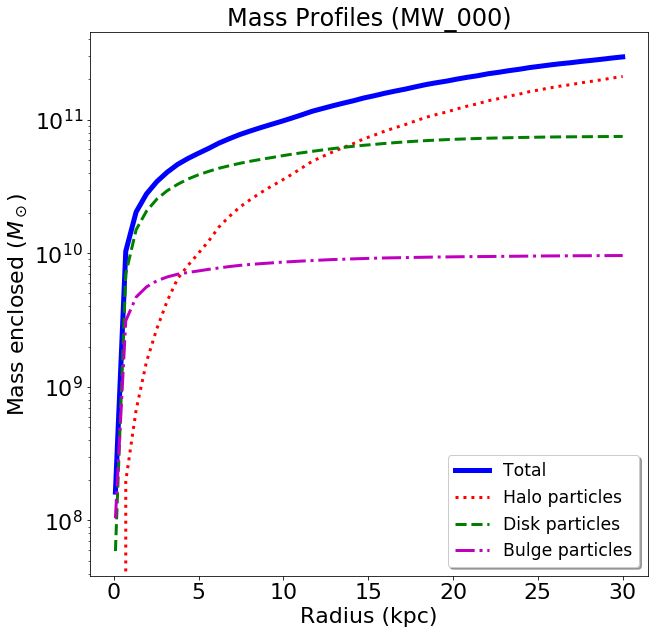

In [19]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.semilogy(radii, mp.mass_enclosed_total(radii), 'b-', lw=5, label='Total')
ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, label='Halo particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 2), 'g--', lw=3, label='Disk particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 3), 'm-.', lw=3, label='Bulge particles')

#adjust tick label font size
label_size = 20
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels
ax.set_xlabel('Radius (kpc)', fontsize=22)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.set_title(f'Mass Profiles ({gname})', fontsize=24)

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='xx-large', shadow=True)


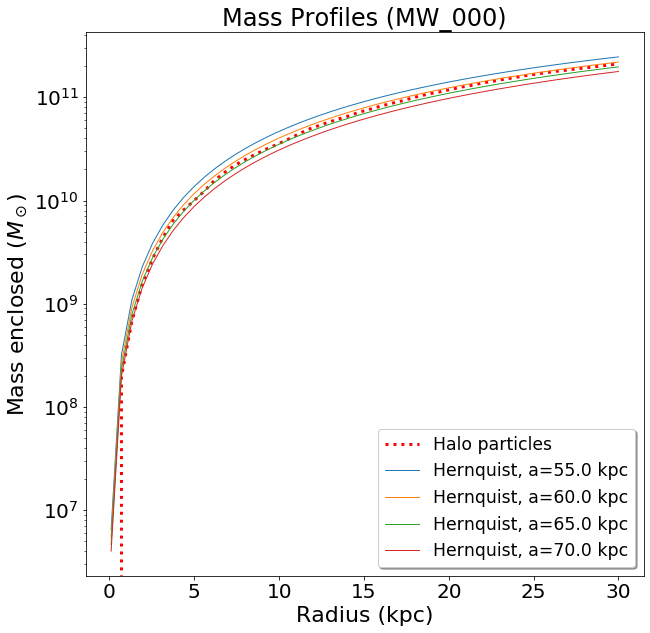

In [25]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, label='Halo particles')
for a in np.arange(55, 75, 5) * u.kpc:
    ax.semilogy(radii, mp.hernquist_mass(radii, a), lw=1, label=f'Hernquist, a={a}')
    
#adjust tick label font size
label_size = 20
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels
ax.set_xlabel('Radius (kpc)', fontsize=22)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.set_title(f'Mass Profiles ({gname})', fontsize=24)

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='xx-large', shadow=True)


In [37]:
names = g.filenames
mass_profiles =[(gname, MassProfile(g.galaxies[gname])) for gname in names]

In [40]:
mass_profiles

[('MW_000', <galaxy.massprofile.MassProfile at 0x7f7676bed9e8>),
 ('M31_000', <galaxy.massprofile.MassProfile at 0x7f7676bed6d8>),
 ('M33_000', <galaxy.massprofile.MassProfile at 0x7f76765b5e80>)]

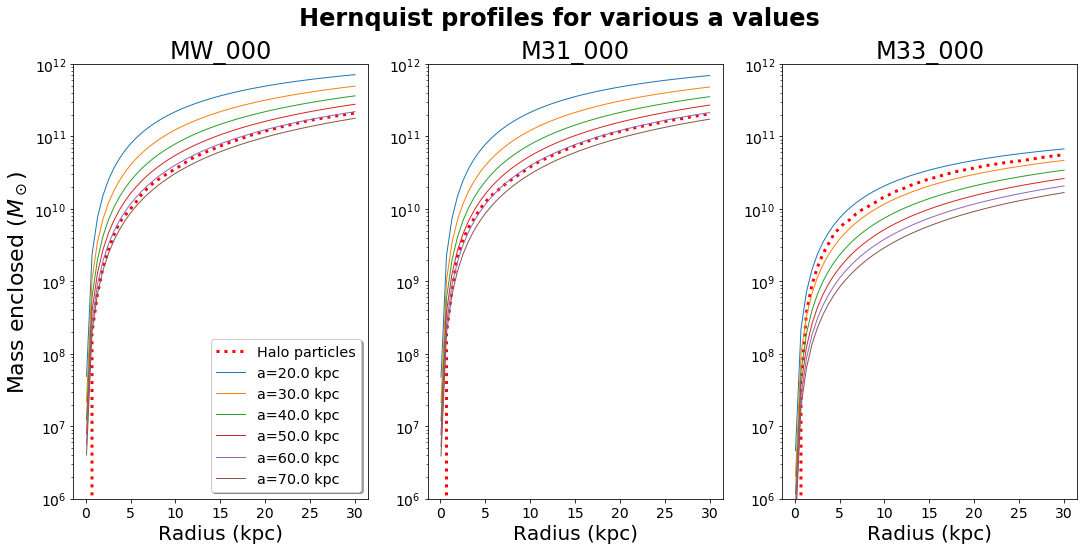

In [56]:
assert len(names) == 3
fig = plt.figure(figsize=(18,8))
subplots = (131, 132, 133)

for i in range(len(names)):
    ax = plt.subplot(subplots[i])
    gname, mp = mass_profiles[i]
    ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, label='Halo particles')
    for a in np.arange(20, 80, 10) * u.kpc:
        ax.semilogy(radii, mp.hernquist_mass(radii, a), lw=1, label=f'a={a}')
        
    #set axis limits
    ax.set_ylim(1e6, 1e12)


    #adjust tick label font size
    label_size = 14
    rcParams['xtick.labelsize'] = label_size 
    rcParams['ytick.labelsize'] = label_size

    # Add labels
    ax.set_xlabel('Radius (kpc)', fontsize=20)
    if i == 0: # left subplot only
        ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
        ax.legend(loc='lower right',fontsize='x-large', shadow=True)

    ax.set_title(gname, fontsize=24)
    
fig.suptitle('Hernquist profiles for various a values', fontsize=24, weight='bold');

In [28]:
gname = 'M33_000'
mp = MassProfile(g.galaxies[gname])

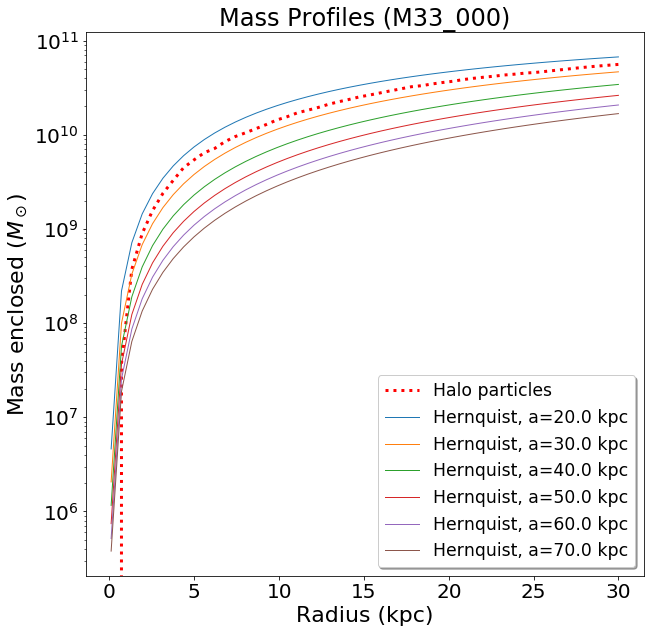

In [31]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, label='Halo particles')
for a in np.arange(20, 80, 10) * u.kpc:
    ax.semilogy(radii, mp.hernquist_mass(radii, a), lw=1, label=f'Hernquist, a={a}')
    
#adjust tick label font size
label_size = 20
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels
ax.set_xlabel('Radius (kpc)', fontsize=22)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.set_title(f'Mass Profiles ({gname})', fontsize=24)

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='xx-large', shadow=True)